# Visión por Computadora I #

## CEIA 21Co2025 ##

## TP2 ##

José Luis Diaz (diazjoseluis@gmail.com)

Ricardo Silvera (rsilvera@thalu.com.ar)

José Aviani (jose.aviani@gmail.com)


---

Importar librerias:

In [1]:
%pip install --upgrade pip setuptools wheel
%pip install numpy matplotlib opencv-python
%pip install numpy matplotlib opencv-python-headless

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Callable

---

#### Métricas de enfoque ####

Image Quality Measure (FM):

Paper "Image Sharpness Measure for Blurred Images in Frequency Domain"

In [3]:
def fm_frequency_metric(gray: np.ndarray) -> float:
    """
    Métrica FM (De & Masilamani, 2013):
      1) F = FFT2(gray)
      2) Fc = fftshift(F)
      3) AF = |Fc|
      4) M = max(AF)
      5) TH = # {AF > M/1000}
      6) FM = TH / (H*W)
    """
    I = gray.astype(np.float64)
    F = np.fft.fft2(I)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    M = AF.max()
    if M <= 0:
        return 0.0
    thres = M / 1000.0
    TH = np.count_nonzero(AF > thres)
    H, W = I.shape[:2]
    return float(TH / (H * W))

Elegimos dos métricas del papper "Analysis of focus measure operators in shape-from-focus"

Tenengrad:

In [4]:
def tenengrad_metric(gray: np.ndarray, ksize: int = 3) -> float:
    """
    Tenengrad (familia gradiente): energía del gradiente (Sobel).
    """
    g = gray.astype(np.float32)
    gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=ksize)
    gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=ksize)
    return float(np.mean(gx * gx + gy * gy))

Varianza del Laplaciano:

In [5]:
def var_laplacian_metric(gray: np.ndarray, ksize: int = 3) -> float:
    """
    Varianza del Laplaciano (familia Laplaciano).
    """
    g = gray.astype(np.float32)
    lap = cv2.Laplacian(g, cv2.CV_32F, ksize=ksize)
    return float(lap.var())

Declaramos  variables y métodos necesarios:

In [6]:
# Selector de métrica por por nombre
METRICS: Dict[str, Callable[..., float]] = {
    "fm": fm_frequency_metric,
    "tenengrad": tenengrad_metric,
    "var_laplacian": var_laplacian_metric
}



# utilizades para ROI
def central_square_roi(img: np.ndarray, area_frac: float) -> Tuple[np.ndarray, Tuple[int,int,int,int]]:
    """
    ROI cuadrada centrada con área = area_frac * área_imagen.
    Retorna (roi, (x0, y0, x1, y1)).
    """
    h, w = img.shape[:2]
    target_area = max(1.0, area_frac * (h * w))
    side = int(round(math.sqrt(target_area)))
    side = max(2, min(side, h, w))
    cx, cy = w // 2, h // 2
    x0 = max(0, cx - side // 2)
    y0 = max(0, cy - side // 2)
    x1 = min(w, x0 + side)
    y1 = min(h, y0 + side)
    roi = img[y0:y1, x0:x1]
    return roi, (x0, y0, x1, y1)



# Series/estrucruras para guardar resultados
@dataclass
class FMSeries:
    frames: List[int]
    times: List[float]
    values: List[float]
    label: str
    maxima_idx: Optional[int] = None



# aplicar metricas a cada frame del video
def compute_metric_over_video(
    video_path: str,
    metric_name: str,
    roi_modes: Dict[str, Optional[float]],
    metric_kwargs: Optional[dict] = None,
    max_frames: Optional[int] = None,
) -> List[FMSeries]:
    """
    Aplica la métrica elegida a cada frame.
    """
    metric_fn = METRICS[metric_name]
    metric_kwargs = metric_kwargs or {}

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"No se purde abrir el video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    series_dict = {label: FMSeries([], [], [], label) for label in roi_modes.keys()}

    frame_idx = 0
    while True:
        ok, frame_bgr = cap.read()
        if not ok:
            break
        if max_frames is not None and frame_idx >= max_frames:
            break

        gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        for label, area_frac in roi_modes.items():
            img_in = gray
            if area_frac is not None:
                roi, _ = central_square_roi(gray, area_frac)
                img_in = roi
            val = metric_fn(img_in, **metric_kwargs) if metric_kwargs else metric_fn(img_in)
            s = series_dict[label]
            s.frames.append(frame_idx)
            t = frame_idx / fps if fps > 1e-6 else float(frame_idx)
            s.times.append(t)
            s.values.append(float(val))

        frame_idx += 1

    cap.release()

    # Detección automática de máximo global
    for s in series_dict.values():
        if len(s.values) > 0:
            s.maxima_idx = int(np.argmax(s.values))
        else:
            s.maxima_idx = None

    return list(series_dict.values())

Zona de enfoque:

Lo definimos como un porcentaje de variación de la métrica de enfoque respecto al máximo (100%) y al mínimo (0%). Por ejemplo, si la definimos en 10%, quiere decir que la zona de enfoque es la que tiene 90% o más de enfoque.

In [7]:
# definimos la zona de enoque en 10%
zona_enfoque_pct = 0.10

# encontrar la zona de enfoque
def find_focus_zone(values: List[float], peak_idx: int) -> Tuple[int, int]:
    if peak_idx is None or peak_idx < 0 or peak_idx >= len(values):
        return (None, None)

    vmax = values[peak_idx]
    vmin = min(values) if len(values) else vmax
    if vmax <= vmin:
        return (peak_idx, peak_idx)

    thr = vmax - zona_enfoque_pct * (vmax - vmin)

    # Hacia atrás (lado ascendente): detener cuando el anterior cae por DEBAJO del umbral
    i0 = peak_idx
    while i0 - 1 >= 0 and values[i0 - 1] >= thr:
        i0 -= 1

    # Hacia adelante (lado descendente)
    i1 = peak_idx
    while i1 + 1 < len(values) and values[i1 + 1] >= thr:
        i1 += 1

    return (i0, i1)


In [8]:
# graficar las curvas
def plot_series(
    series_list: List[FMSeries],
    x_axis: str = "time",
    title: str = "",
    out_path: Optional[str] = None,
    zones: Optional[Dict[str, Tuple[int,int]]] = None  # label -> (start_idx, end_idx)
):
    """
    Dibuja curvas y marca:
      - el punto del máximo,
      - los puntos 'desde' y 'hasta' de la zona de enfoque,
    """
    if x_axis not in ("time", "frame"):
        x_axis = "time"

    fig, ax = plt.subplots(figsize=(10, 5))

    for s in series_list:
        x = s.times if x_axis == "time" else s.frames

        # Dibujar línea y recuperar color
        line, = ax.plot(x, s.values, label=s.label)
        c = line.get_color()

        # Máximo: punto con mismo color
        if s.maxima_idx is not None:
            xm = x[s.maxima_idx]
            ym = s.values[s.maxima_idx]
            ax.scatter([xm], [ym], marker="o", s=35, color=c, zorder=3)

        # Zona de enfoque: puntos "desde" y "hasta" con el mismo color, sin texto
        if zones and s.label in zones and zones[s.label] is not None:
            i0, i1 = zones[s.label]
            if i0 is not None and 0 <= i0 < len(x):
                x0, y0 = x[i0], s.values[i0]
                ax.scatter([x0], [y0], marker="o", s=30, color=c, zorder=3)
            if i1 is not None and 0 <= i1 < len(x):
                x1, y1 = x[i1], s.values[i1]
                ax.scatter([x1], [y1], marker="o", s=30, color=c, zorder=3)

    ax.set_xlabel("Tiempo [s]" if x_axis == "time" else "Frame #")
    ax.set_ylabel("Valor de la métrica")
    ax.set_title(title, pad=12)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)  # leyenda afuera
    fig.tight_layout(rect=[0.0, 0.0, 0.80, 1.0])
    ax.grid(True)

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, bbox_inches="tight")
    plt.show()


# lee un frame por índice y lo devuelve en RGB
def read_frame_rgb(video_path: str, frame_index: int) -> Optional[np.ndarray]:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, bgr = cap.read()
    cap.release()
    if not ok:
        return None
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb


# motsrar grilla de imágenes
def show_series_images_grid(images_map: Dict[str, Tuple[np.ndarray, np.ndarray]], title: str = ""):
    """
    Muestra una grilla de imágenes 2 x K:
      - Fila 1: frame de MÁXIMO enfoque por serie.
      - Fila 2: frame desde (inicio de zona) por serie.
    """
    if not images_map:
        return
    labels = list(images_map.keys())
    K = len(labels)
    fig, axes = plt.subplots(2, K, figsize=(4*K, 6))
    if title:
        fig.suptitle(title, y=0.98)

    if K == 1:
        axes = np.array(axes).reshape(2, 1)

    for j, label in enumerate(labels):
        img_max, img_from = images_map[label]
        # Fila 1: máximo
        ax1 = axes[0, j]
        ax1.imshow(img_max)
        ax1.set_title(f"Máximo enfoque — {label}")
        ax1.axis("off")
        # Fila 2: desde
        ax2 = axes[1, j]
        ax2.imshow(img_from)
        ax2.set_title(f"Frame zona de enfoque desde — {label}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()


def grid_label(N: int, M: int) -> str:
    return f"Arreglo {N}x{M}"


# devuelve la lista de rectángulos (x0,y0,x1,y1) para una grilla NxM:
def compute_centered_grid_rects(H: int, W: int, N: int, M: int, size: float) -> List[Tuple[int,int,int,int]]:
    assert N % 2 == 1 and M % 2 == 1, "N y M deben ser impares"
    base = min(H, W)
    side_req = int(round(size * base))
    side_req = max(2, side_req)

    # Para que entre: ancho total = (2*M - 1)*side; alto total = (2*N - 1)*side
    max_side_w = W // (2 * M - 1)
    max_side_h = H // (2 * N - 1)
    side = max(2, min(side_req, max_side_w, max_side_h))
    gap = side
    step = side + gap  # = 2*side
    half = side // 2

    cx, cy = W // 2, H // 2
    r, c = N // 2, M // 2

    rects = []
    for i in range(-r, r + 1):
        for j in range(-c, c + 1):
            x_center = cx + j * step
            y_center = cy + i * step
            x0 = max(0, x_center - half)
            y0 = max(0, y_center - half)
            x1 = min(W, x_center + half)
            y1 = min(H, y_center + half)
            if x1 > x0 and y1 > y0:
                rects.append((x0, y0, x1, y1))
    return rects


Cargamos el video:

In [9]:
video = os.path.join("data", "focus_video.mov")

Calculamos las métricas para los tres algoritmos, para el video original, ROI 5% y ROI 10%, calculamos el máximo enfoque y la zona de enfoque. Mostramos los resultados, graficamos y mostramos las imágenes correspondientes:

--------------------------------------------------------------------------------------------------------------

Métrica: FM (De & Masilamani, 2013)
- Video completo:
    * Máximo enfoque: frame #109 | tiempo = 3.637s | valor métrica = 0.028624
    * Zona de enfoque (thr = 0.026444 = vmax - 0.10·(vmax-vmin)):
        . desde frame #82 (tiempo = 2.736s, valor métrica = 0.026523)
        . hasta frame #114 (tiempo = 3.804s, valor métrica = 0.026784)
- ROI 5%:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 0.473491
    * Zona de enfoque (thr = 0.432405 = vmax - 0.10·(vmax-vmin)):
        . desde frame #105 (tiempo = 3.504s, valor métrica = 0.446240)
        . hasta frame #113 (tiempo = 3.770s, valor métrica = 0.446065)
- ROI 10%:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 0.345914
    * Zona de enfoque (thr = 0.314898 = vmax - 0.10·(vmax-vmin)):
        . desde frame #101 (tiempo = 3.370s, valor métrica = 0.337301)
        . hasta frame #113 

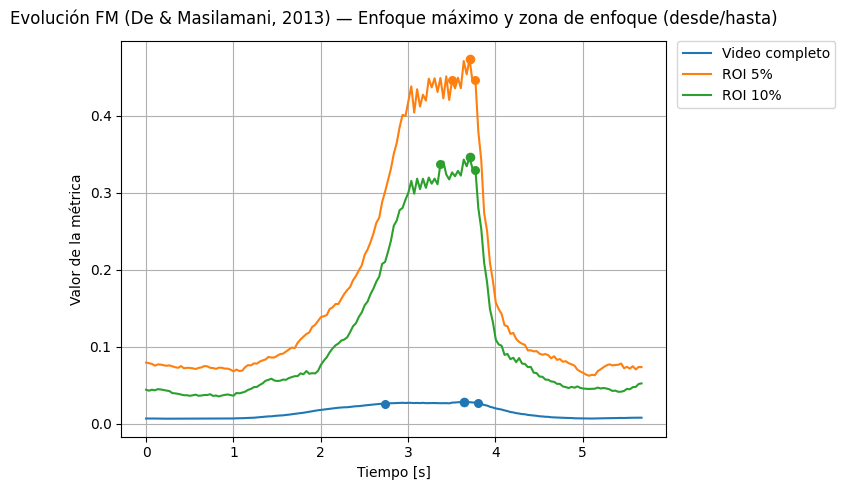

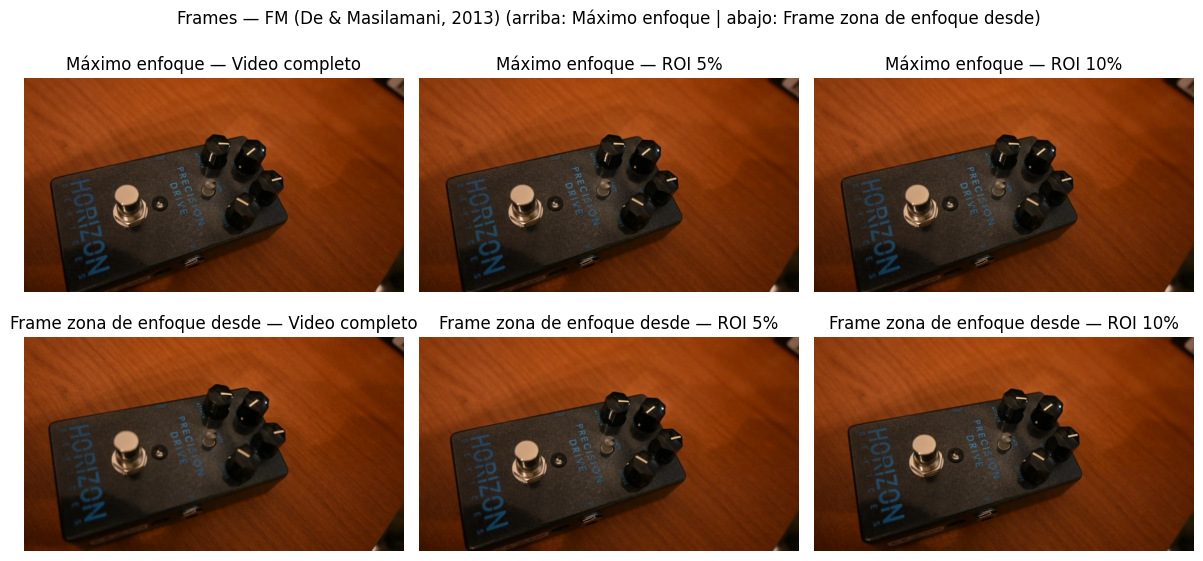

--------------------------------------------------------------------------------------------------------------

Métrica: Tenengrad (gradiente)
- Video completo:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 2274.630615
    * Zona de enfoque (thr = 2058.753644 = vmax - 0.10·(vmax-vmin)):
        . desde frame #95 (tiempo = 3.170s, valor métrica = 2075.095947)
        . hasta frame #113 (tiempo = 3.770s, valor métrica = 2166.955811)
- ROI 5%:
    * Máximo enfoque: frame #112 | tiempo = 3.737s | valor métrica = 7391.328613
    * Zona de enfoque (thr = 6666.115063 = vmax - 0.10·(vmax-vmin)):
        . desde frame #107 (tiempo = 3.570s, valor métrica = 6872.764648)
        . hasta frame #113 (tiempo = 3.770s, valor métrica = 7234.006836)
- ROI 10%:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 7898.139648
    * Zona de enfoque (thr = 7122.354709 = vmax - 0.10·(vmax-vmin)):
        . desde frame #105 (tiempo = 3.504s, valor métrica = 7295.926758)

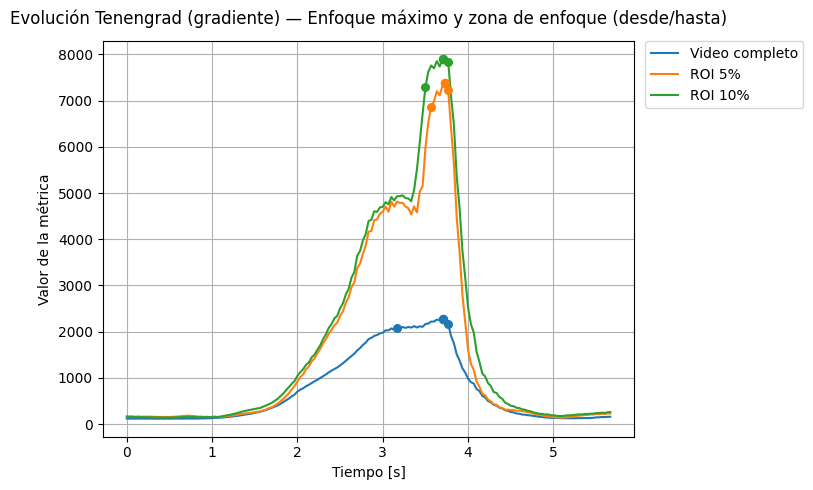

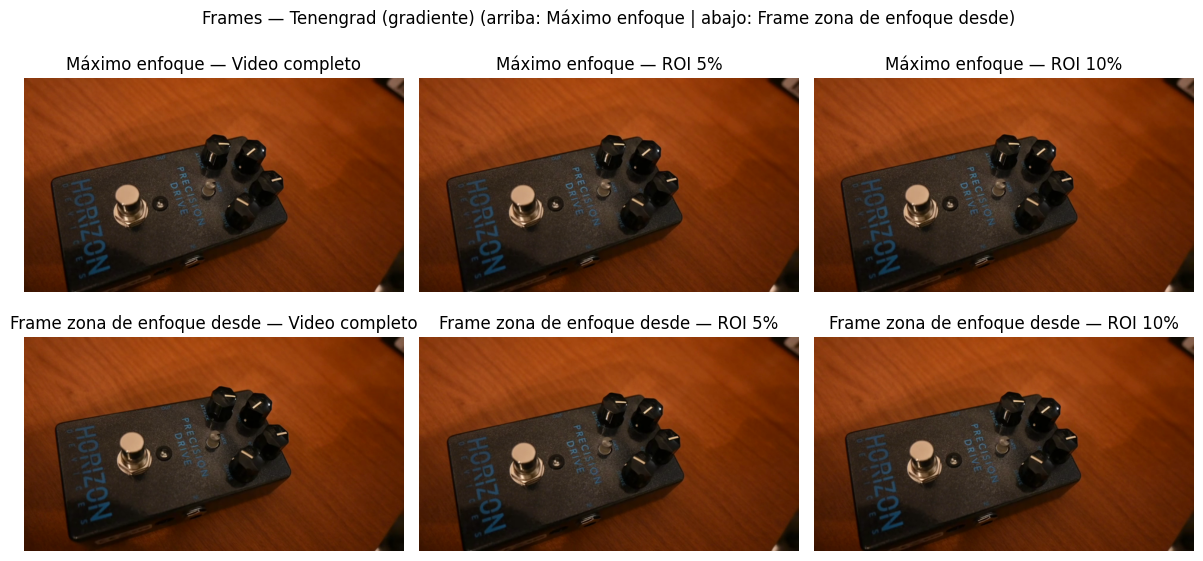

--------------------------------------------------------------------------------------------------------------

Métrica: Varianza del Laplaciano
- Video completo:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 1074.993164
    * Zona de enfoque (thr = 969.470150 = vmax - 0.10·(vmax-vmin)):
        . desde frame #105 (tiempo = 3.504s, valor métrica = 993.955566)
        . hasta frame #112 (tiempo = 3.737s, valor métrica = 970.520874)
- ROI 5%:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 4275.151855
    * Zona de enfoque (thr = 3850.201481 = vmax - 0.10·(vmax-vmin)):
        . desde frame #109 (tiempo = 3.637s, valor métrica = 4160.364746)
        . hasta frame #113 (tiempo = 3.770s, valor métrica = 4009.933838)
- ROI 10%:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 4244.086426
    * Zona de enfoque (thr = 3822.125355 = vmax - 0.10·(vmax-vmin)):
        . desde frame #106 (tiempo = 3.537s, valor métrica = 3882.160645)

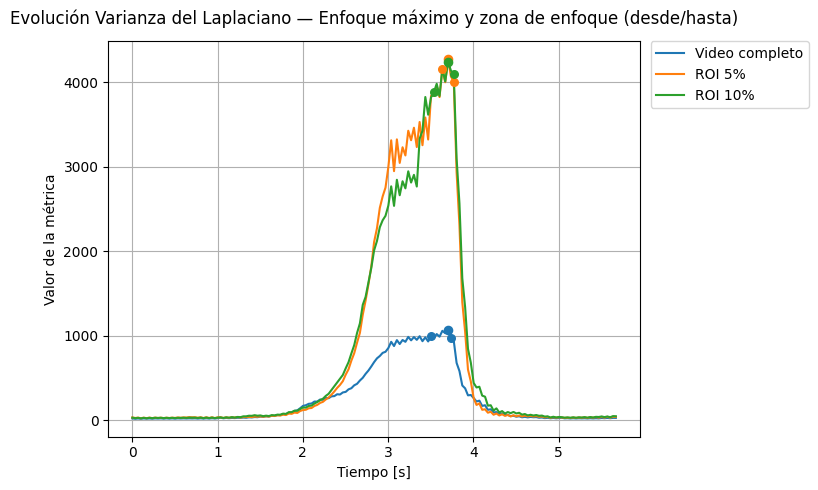

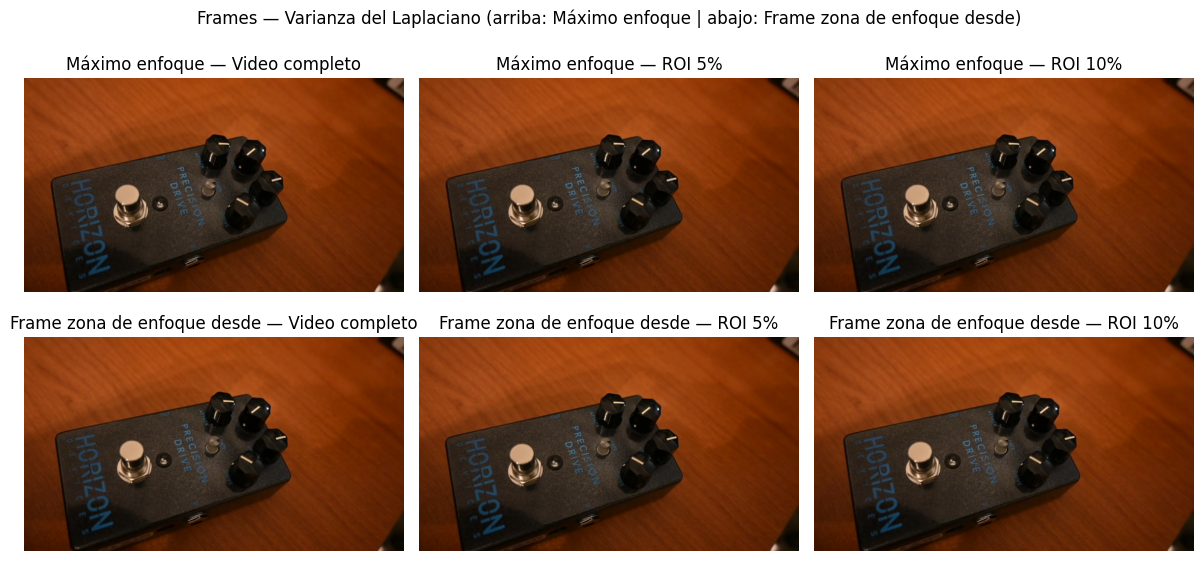

--------------------------------------------------------------------------------------------------------------


In [10]:
# Configuraciones Video completo, ROI 5% y ROI 10%
roi_modes = {"Video completo": None, "ROI 5%": 0.05, "ROI 10%": 0.10}


pretty = {
    "fm": "FM (De & Masilamani, 2013)",
    "tenengrad": "Tenengrad (gradiente)",
    "var_laplacian": "Varianza del Laplaciano"
}


# para cada algoritmo
for metric_name in ["fm", "tenengrad", "var_laplacian"]:
    
    # calculamos la serie
    series = compute_metric_over_video(
        video_path=video,
        metric_name=metric_name,
        roi_modes=roi_modes
    )

    print('-' * 110)
    print(f"\nMétrica: {pretty.get(metric_name, metric_name)}")

    zones: Dict[str, Tuple[int,int]] = {}
    images_map: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}  # label

    # para cada serie
    for s in series:
        if s.maxima_idx is None or len(s.values) == 0:
            zones[s.label] = None
            print(f"- {s.label}: sin datos")
            continue

        # Máximo
        i_peak = s.maxima_idx
        frame_peak = s.frames[i_peak]
        time_peak = s.times[i_peak]
        vmax = s.values[i_peak]
        vmin = min(s.values)
        thr_zone = vmax - zona_enfoque_pct * (vmax - vmin)

        # Zona de enfoque (desde/hasta)
        i0, i1 = find_focus_zone(s.values, i_peak)
        zones[s.label] = (i0, i1)

        val_from = s.values[i0] if i0 is not None else None
        val_to   = s.values[i1] if i1 is not None else None

        frame_from = s.frames[i0] if i0 is not None else None
        time_from  = s.times[i0] if i0 is not None else None

        frame_to   = s.frames[i1] if i1 is not None else None
        time_to    = s.times[i1] if i1 is not None else None

        print(f"- {s.label}:")
        print(f"    * Máximo enfoque: frame #{frame_peak} | tiempo = {time_peak:.3f}s | valor métrica = {vmax:.6f}")
        print(f"    * Zona de enfoque (thr = {thr_zone:.6f} = vmax - {zona_enfoque_pct:.2f}·(vmax-vmin)):")
        print(f"        . desde frame #{frame_from} (tiempo = {time_from:.3f}s, valor métrica = {val_from:.6f})")
        print(f"        . hasta frame #{frame_to} (tiempo = {time_to:.3f}s, valor métrica = {val_to:.6f})")

        # Imágenes a mostrar: frame de máximo enfoque y frame desde de zona de enfoque
        img_max  = read_frame_rgb(video, frame_peak) if frame_peak is not None else None
        img_from = read_frame_rgb(video, frame_from) if frame_from is not None else None
        if img_max is not None and img_from is not None:
            images_map[s.label] = (img_max, img_from)

    # Gráfico de curvas con puntos (máximo, desde, hasta)
    plot_series(
        series,
        x_axis="time",
        title=f"Evolución {pretty.get(metric_name, metric_name)} — Enfoque máximo y zona de enfoque (desde/hasta)",
        out_path=f"out/{metric_name}_full_roi_zone_points.png",
        zones=zones
    )

    # mostrar imágenes de máximo y desde para cada curva
    show_series_images_grid(images_map, title=f"Frames — {pretty.get(metric_name, metric_name)} (arriba: Máximo enfoque | abajo: Frame zona de enfoque desde)")

print('-' * 110)

#### Conclusiones: ####

##### FM (De & Masilamani, 2013): #####

* En ROIs el pico de enfoque aparece ligeramente después que en el video completo, indicando que el detalle central alcanza su óptimo un poco más tarde que el promedio global.

* Al medir en regiones centrales pequeñas, la zona de enfoque se vuelve más compacta; la ROI menor ofrece mayor precisión temporal, la mayor más robustez sin mover el pico.

* Los valores FM son más altos en ROIs, coherente con mayor concentración de alta frecuencia en el centro.

* La dinámica alrededor del pico es asimétrica: el enfoque asciende gradual y desciende más rápido tras el máximo.

* La coincidencia del pico entre ROIs de distinto tamaño confirma que el máximo está bien localizado en la zona central; ampliar la región solo ensancha la franja en foco.

##### Tenengrad (gradiente): #####

* El pico de enfoque en ROIs es muy cercano al del video completo; la ROI 5% aparece apenas desfasada hacia después, mientras que ROI 10% coincide con el instante global.

* Al reducir la región a la zona central, la ventana en foco se acota, aportando más precisión temporal; la ROI más grande mantiene robustez sin desplazar el pico.

* Las magnitudes de Tenengrad son notablemente mayores en ROIs, consistente con gradientes más intensos en el área de mayor detalle.

* La evolución alrededor del máximo es asimétrica: ascenso más gradual y descenso más rápido tras el pico, patrón que se conserva al usar ROIs.

* La coincidencia del máximo entre el video completo y ROIs confirma una localización estable del foco en el centro; ampliar la región solo ensancha moderadamente la franja considerada en foco.

##### Varianza del Laplaciano: #####

* El instante de máximo enfoque coincide entre el video completo y ROIs, indicando una localización temporal muy estable del foco.

* Al medir en la zona central, la ventana en foco se vuelve más compacta, con mayor precisión temporal que en el análisis del cuadro completo.

* Las magnitudes de la métrica son sensiblemente mayores en ROIs, coherente con la concentración de bordes/altas frecuencias en el centro.

* La evolución alrededor del pico mantiene asimetría temporal: subida más suave y caída más rápida, patrón que se preserva al usar ROIs.

* La coincidencia del pico entre ROIs de distinto tamaño sugiere un foco bien localizado espacialmente; ampliar la región solo ensancha levemente la franja considerada en foco sin desplazar el máximo.

##### Comparación: #####

* Los tres métodos coinciden en el instante de foco dentro de un margen muy pequeño; Tenengrad y Var. Laplaciano muestran la mayor estabilidad temporal, mientras que FM presenta un leve desfase entre el video completo y ROIs.

* Al usar ROIs centrales, en los tres casos la zona en foco se acota y las magnitudes aumentan, reflejando mayor concentración de detalle en el centro.

* La dinámica temporal alrededor del pico es similar: ascenso gradual y descenso más brusco, con la misma pauta en el video completo y ROIs.

* Tenengrad y Var. Laplaciano (ambos basados en derivadas) exhiben comportamiento muy consistente entre sí; FM (dominio de frecuencia) es coherente en tendencia pero más sensible a la elección de región.

---

####  Matriz de enfoque compuesta arreglos: ####

In [11]:
# dibujar en verde el borde de cada elemento de la grilla
def overlay_grid_boxes(img_rgb: np.ndarray, N: int, M: int, size: float, color: Tuple[int,int,int]=(0,255,0), thickness: int = 2) -> np.ndarray:
    H, W = img_rgb.shape[:2]
    rects = compute_centered_grid_rects(H, W, N, M, size)
    out = img_rgb.copy()
    for (x0, y0, x1, y1) in rects:
        cv2.rectangle(out, (x0, y0), (x1, y1), color, thickness)
    return out


# calcular el promedio de la métrica en todas las celdas de la grilla
def metric_grid_over_frame(gray: np.ndarray, metric_name: str, N: int, M: int, size: float, metric_kwargs: Optional[dict] = None) -> float:
    H, W = gray.shape[:2]
    rects = compute_centered_grid_rects(H, W, N, M, size)
    metric_fn = METRICS[metric_name]
    metric_kwargs = metric_kwargs or {}
    vals = []
    for (x0, y0, x1, y1) in rects:
        cell = gray[y0:y1, x0:x1]
        vals.append(metric_fn(cell, **metric_kwargs) if metric_kwargs else metric_fn(cell))
    return float(np.mean(vals)) if len(vals) else 0.0


# Medición sobre matriz NxM
def compute_metric_grid_over_video(
    video_path: str,
    metric_name: str,
    grid_list: List[Tuple[int,int]],
    size: float,
    sample_every: int = 1,
    metric_kwargs: Optional[dict] = None,
    max_frames: Optional[int] = None
):
    """
    Devuelve: dict {(N,M) -> FMSeries} con el promedio de la métrica por frame.
    """
    metric_fn = METRICS[metric_name]
    metric_kwargs = metric_kwargs or {}

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"No se puede abrir el video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

    series = {(N, M): FMSeries([], [], [], grid_label(N, M)) for (N, M) in grid_list}

    frame_idx = 0
    kept = 0
    while True:
        ok, frame_bgr = cap.read()
        if not ok:
            break
        if max_frames is not None and kept >= max_frames:
            break

        if frame_idx % sample_every == 0:
            gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
            for (N, M), s in series.items():
                val_mean = metric_grid_over_frame(gray, metric_name, N, M, size, metric_kwargs)
                s.values.append(val_mean)
                s.frames.append(frame_idx)
                t = frame_idx / fps if fps > 1e-6 else float(frame_idx)
                s.times.append(t)
            kept += 1

        frame_idx += 1

    cap.release()
    for s in series.values():
        s.maxima_idx = int(np.argmax(s.values)) if len(s.values) else None
    return series


Calculamos las métricas promedio para diferentes arreglos con el algoritmo FM para el video original, calculamos el máximo enfoque y la zona de enfoque. Mostramos los resultados, graficamos y mostramos las imágenes correspondientes:


Promedio por arreglo — FM (De & Masilamani, 2013) - Video completo
- Arreglo 3x3:
    * Máximo enfoque: frame #111 | tiempo = 3.704s | valor métrica = 0.904270
    * Zona de enfoque (thr = 3822.125355 = vmax - 0.10·(vmax-vmin)):
       . desde frame #108 (tiempo = 3.537s, valor métrica = 3882.160645)
       . hasta frame #113 (tiempo = 3.770s, valor métrica=4097.880859)
- Arreglo 5x5:
    * Máximo enfoque: frame #91 | tiempo = 3.704s | valor métrica = 0.792562
    * Zona de enfoque (thr = 3822.125355 = vmax - 0.10·(vmax-vmin)):
       . desde frame #86 (tiempo = 3.537s, valor métrica = 3882.160645)
       . hasta frame #113 (tiempo = 3.770s, valor métrica=4097.880859)
- Arreglo 5x7:
    * Máximo enfoque: frame #91 | tiempo = 3.704s | valor métrica = 0.709209
    * Zona de enfoque (thr = 3822.125355 = vmax - 0.10·(vmax-vmin)):
       . desde frame #86 (tiempo = 3.537s, valor métrica = 3882.160645)
       . hasta frame #113 (tiempo = 3.770s, valor métrica=4097.880859)


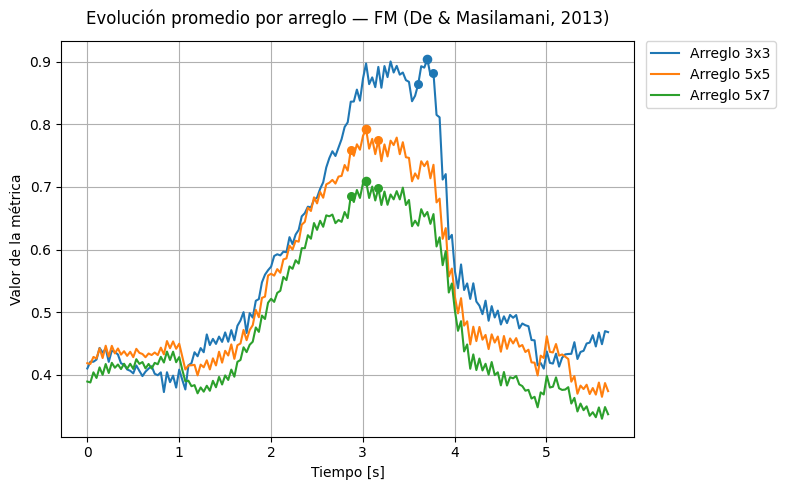

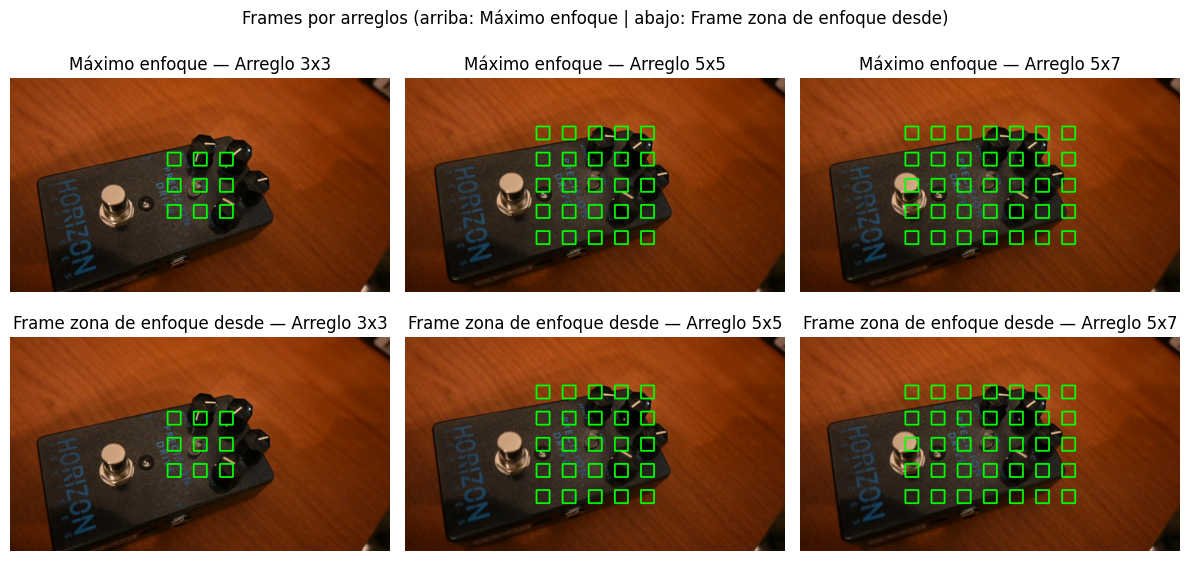

In [12]:
# Configuraciones para diferentes arreglos
grid_cfgs = [(3, 3), (5, 5), (5, 7)]
grid_size = 0.06


# Usamos la métrica FM
metric_name = "fm"
series_grid = compute_metric_grid_over_video(
    video_path=video,
    metric_name=metric_name,
    grid_list=grid_cfgs,
    size=grid_size
)

print(f"\nPromedio por arreglo — {pretty.get(metric_name, metric_name)} - Video completo")

# Calcular zonas de enfoque y preparar imágenes con overlays de grilla
zones_grid: Dict[str, Tuple[int,int]] = {}
images_map_grid: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

for (N, M), s in series_grid.items():
    if s.maxima_idx is None or len(s.values) == 0:
        zones_grid[s.label] = None
        continue

    i_peak = s.maxima_idx
    vmax = s.values[i_peak]
    vmin = min(s.values)
    # umbral de zona de enfoque
    i0, i1 = find_focus_zone(s.values, i_peak)
    zones_grid[s.label] = (i0, i1)

    frame_peak = s.frames[i_peak]
    frame_from = s.frames[i0] if i0 is not None else None

    # Leer frames y dibujar el borde verde de elementos
    img_max  = read_frame_rgb(video, frame_peak) if frame_peak is not None else None
    img_from = read_frame_rgb(video, frame_from) if frame_from is not None else None
    if img_max is not None:
        img_max = overlay_grid_boxes(img_max, N, M, grid_size, color=(0,255,0), thickness=2)
    if img_from is not None:
        img_from = overlay_grid_boxes(img_from, N, M, grid_size, color=(0,255,0), thickness=2)

    if img_max is not None and img_from is not None:
        images_map_grid[s.label] = (img_max, img_from)

    print(f"- {s.label}:")
    print(f"    * Máximo enfoque: frame #{frame_peak} | tiempo = {time_peak:.3f}s | valor métrica = {vmax:.6f}")
    print(f"    * Zona de enfoque (thr = {thr_zone:.6f} = vmax - {zona_enfoque_pct:.2f}·(vmax-vmin)):")
    print(f"       . desde frame #{frame_from} (tiempo = {time_from:.3f}s, valor métrica = {val_from:.6f})")
    print(f"       . hasta frame #{frame_to} (tiempo = {time_to:.3f}s, valor métrica={val_to:.6f})")


# Gráfico de la evolución promedio por arreglo
plot_series(
    list(series_grid.values()),
    x_axis="time",
    title=f"Evolución promedio por arreglo — FM (De & Masilamani, 2013)",
    out_path="out/fm_grids_zone_points.png",
    zones=zones_grid
)


# imagenes
show_series_images_grid(
    images_map_grid,
    title="Frames por arreglos (arriba: Máximo enfoque | abajo: Frame zona de enfoque desde)"
)

#### Conclusiones: ####

* El promedio por arreglo mantiene el foco en torno al mismo intervalo temporal del video, pero el instante del pico varía con la densidad del arreglo: el 3×3 se alinea mejor con el foco central, mientras que arreglos más densos muestran un desfase por el mayor alisado espacial.

* Al aumentar la cantidad de celdas (de 3×3 a 5×5/5×7), la magnitud promedio de FM disminuye, efecto esperable al promediar regiones con detalles menos nítidos junto con las más enfocadas.

* Los arreglos más densos tienden a ensanchar la zona en foco (inicio más temprano), reflejando una mayor robustez del promedio espacial frente a variaciones locales, a costa de menor precisión temporal.

* El 3×3 ofrece una respuesta más selectiva (pico más consistente con el centro y zona más acotada), mientras que 5×5/5×7 actúan como un filtro espacial que suaviza y prolonga el periodo considerado en foco.

* En conjunto, los tres arreglos concuerdan en el vecindario temporal del enfoque máximo; la principal diferencia es el compromiso entre precisión y robustez que introduce el nivel de particionado.

---

#### Unsharp Masking: ####

Zona intermedia:

Similarmente a como hicimos con la zona de resolución, definimos un porcentaje de variación para determinar la zona de enfoque intermedio. Lo vamos a utilizar para encontrar un frame al que le vamos a aplicar sharp masking. Por ejemplo, si la definimos en 20%, vamos a buscar un frame que tenga un 20% menos de enfoque que el de máximo enfoque. Tiene que estar fuera de la zona de enfoque, pero no lejos.

In [13]:
# definimos el zona intermedia de enfoque en 20%
zona_intermedia_enfoque_pct = 0.20

In [14]:
# Unsharp masking usando GaussianBlur + addWeighted.
def unsharp_mask(gray: np.ndarray, amount: float = 1.0, sigma: float = 1.0) -> np.ndarray:
    """
    gray: imagen en escala de grises (uint8/float).
    amount: cuánto realzar.
    sigma: sigma del blur gaussiano (si 0, OpenCV lo estima con kernel auto).
    """
    g = gray.astype(np.float32)
    blurred = cv2.GaussianBlur(g, ksize=(0,0), sigmaX=sigma, sigmaY=sigma)
    # I_sharp = (1 + amount)*I - amount*blurred
    sharp = cv2.addWeighted(g, 1.0 + amount, blurred, -amount, 0.0)
    sharp = np.clip(sharp, 0, 255).astype(gray.dtype)
    return sharp


# Calcula FM (paper) sobre Full/ROI5/ROI10 para un frame en gris.
def compute_fm_modes_on_gray(gray: np.ndarray, roi_modes: Dict[str, Optional[float]]) -> Dict[str, float]:
    out = {}
    for label, area_frac in roi_modes.items():
        img_in = gray
        if area_frac is not None:
            roi, _ = central_square_roi(gray, area_frac)
            img_in = roi
        out[label] = fm_frequency_metric(img_in)
    return out

Obtenemos el frame que está en la zona intermedia de resolución, aplicamos unsharp masking y mostramos el resultado:


Unsharp Masking
  - Porcentaje de zona intermedia de enfoque = 0.20 (20%)
  - vmin = 0.006819, vmax = 0.028624, thr_intermedio = 0.024263
  - Frame intermedio elegido: #117
  - FM antes vs después (Full / ROI 5% / ROI 10%):
    Video completo  Antes = 0.023928   |   Después = 0.029978
    ROI 5%    Antes = 0.250590   |   Después = 0.363787
    ROI 10%   Antes = 0.183908   |   Después = 0.283025


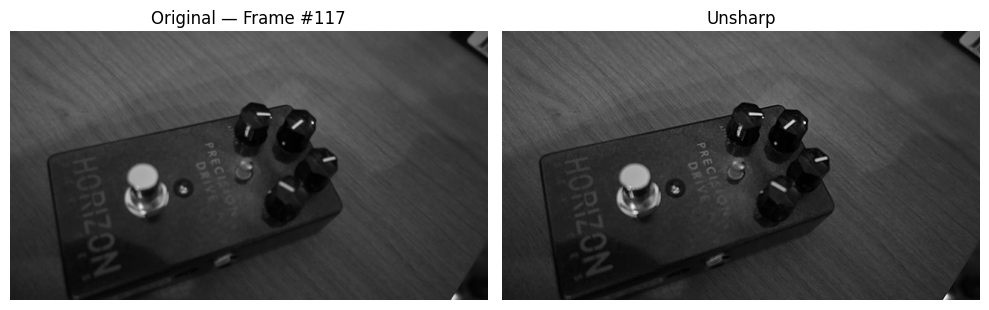

In [15]:
series_fm = compute_metric_over_video(
    video_path=video,
    metric_name="fm",
    roi_modes={"Video completo": None}
)[0]

if series_fm.maxima_idx is not None and len(series_fm.values) > 0:
    vmax = series_fm.values[series_fm.maxima_idx]
    vmin = min(series_fm.values)
    if vmax <= vmin:
        thr_intermedio = vmax
    else:
        thr_intermedio = vmax - zona_intermedia_enfoque_pct * (vmax - vmin)

    # Seleccionamos el primer frame después del pico que cae por debajo a ese umbral
    target_frame_idx = None
    peak_frame_pos = series_fm.maxima_idx
    for pos in range(peak_frame_pos + 1, len(series_fm.values)):
        if series_fm.values[pos] <= thr_intermedio:
            target_frame_idx = series_fm.frames[pos]
            break
    if target_frame_idx is None:
        best_pos = None
        best_dist = 10**9
        for pos, v in enumerate(series_fm.values):
            if v <= thr_intermedio:
                d = abs(pos - peak_frame_pos)
                if d < best_dist:
                    best_dist = d
                    best_pos = pos
        if best_pos is not None:
            target_frame_idx = series_fm.frames[best_pos]
        else:
            # fallback final: usar el propio pico
            target_frame_idx = series_fm.frames[series_fm.maxima_idx]


    # Leer frame en gris
    cap = cv2.VideoCapture(video)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_idx)
    ok, bgr = cap.read()
    cap.release()
    if ok:
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

        # Aplicar unsharp masking para expandir el enfoque y recalcular FM (Full, ROI5, ROI10)
        gray_sharp = unsharp_mask(gray, amount=1.0, sigma=1.0)

        vals_before = compute_fm_modes_on_gray(gray, roi_modes)
        vals_after  = compute_fm_modes_on_gray(gray_sharp, roi_modes)

        print("\nUnsharp Masking")
        print(f"  - Porcentaje de zona intermedia de enfoque = {zona_intermedia_enfoque_pct:.2f} ({int(zona_intermedia_enfoque_pct*100)}%)")
        print(f"  - vmin = {vmin:.6f}, vmax = {vmax:.6f}, thr_intermedio = {thr_intermedio:.6f}")
        print(f"  - Frame intermedio elegido: #{target_frame_idx}")
        print("  - FM antes vs después (Full / ROI 5% / ROI 10%):")
        for label in ["Video completo", "ROI 5%", "ROI 10%"]:
            print(f"    {label:8s}  Antes = {vals_before[label]:.6f}   |   Después = {vals_after[label]:.6f}")

        # Mostrar el frame original y el sharpened
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(gray, cmap="gray")
        axes[0].set_title(f"Original — Frame #{target_frame_idx}")
        axes[0].axis("off")
        axes[1].imshow(gray_sharp, cmap="gray")
        axes[1].set_title("Unsharp")
        axes[1].axis("off")
        plt.tight_layout()
        os.makedirs("out", exist_ok=True)
        plt.savefig("out/puntos_extra_unsharp_comparacion.png", bbox_inches="tight")
        plt.show()
    else:
        print("\n[Unsharp Masking] No se pudo leer el frame objetivo.")
else:
    print("\n[Unsharp Masking] No se pudo calcular la serie FM Full para localizar el máximo/umbral.")


#### Conclusiones: ####

* El realce elevó de forma clara la métrica FM del frame intermedio en el video completo y ROIs, confirmando que el unsharp incrementa el contenido de alta frecuencia percibido como enfoque.

* En el video completo, el valor posterior supera al máximo original, evidenciando una expansión efectiva de la zona considerada en foco alrededor del pico.

* En ROI 5% y ROI 10% el aumento relativo es mayor que en el video completo, aunque los valores resultantes no alcanzan sus picos originales; el realce mejora la nitidez central pero no reubica el máximo.

* El incremento de FM en un frame cercano al umbral sugiere que el unsharp puede ensanchar la ventana temporal de enfoque (más frames superan el umbral definido por el rango dinámico).

* Como efecto colateral, este enfoque puede potenciar ruido y halos en bordes; el beneficio de expansión de zona debe balancearse con la calidad visual resultante.

---